In [ ]:
import environment.utils as utils
import numpy as np

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
market_price = 138/10000  # Example market price
T = 2.0  # Time to expiry (years)
K = 0.04259 - 100/10000  # Strike rate
R = 0.04259  # Forward swap rate

# Example OIS rates and maturities
maturities = [3, 4]  # Payment dates (years)
ois_rates = [0.03, 0.032]  # Corresponding OIS zero rates (3% and 3.2%)


S = 0.866+0.897-0.2

def black_price_swaption(sigma, T, K, S, R, option_type='payer'):
    """
    Black formula for European swaptions including the annuity factor.
    
    Parameters:
        sigma (float): Black implied volatility
        T (float): Time to expiration (years)
        K (float): Strike rate
        S (float): Present value of the fixed leg annuity
        R (float): Forward swap rate
        option_type (str): 'payer' or 'receiver'
    
    Returns:
        float: Black swaption price
    """
    if T == 0:
        return S * max(0, (R - K) if option_type == 'payer' else (K - R))
    
    d1 = (np.log(R / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'payer':
        price = S * (R * norm.cdf(d1) - K * norm.cdf(d2))
    else:  # Receiver swaption
        price = S * (K * norm.cdf(-d2) - R * norm.cdf(-d1))
    #print(sigma, price)
    return price

black_price = black_price_swaption(0.2, T, K, S, R, option_type='payer')

loss = black_price - market_price
print(loss)

0.003339365941290171


In [3]:
from scipy.stats import norm

# Given market data
F = 0.042  # 2y2y forward swap rate (4.2%)
K = 0.042  # Assume ATM strike at the forward swap rate
T = 2.0  # Time to expiry (2 years)
sigma_annualized = 0.2504  # ATM Black volatility (25% per annum)

# Convert annualized volatility to Black model usable volatility
sigma = sigma_annualized * np.sqrt(T)

# Black's formula for swaption pricing
def black_swaption_price(F, K, T, sigma, option_type="payer"):
    """ Computes Black's model price for a European swaption """
    if K <= 0:  # Strike must be positive
        return 0

    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "payer":
        price = F * norm.cdf(d1) - K * norm.cdf(d2)
    else:  # receiver swaption
        price = K * norm.cdf(-d2) - F * norm.cdf(-d1)
    
    return max(price, 0)  # Prices cannot be negative

# Compute ATM swaption prices
payer_swaption_price = black_swaption_price(F, K, T, sigma, "payer")
receiver_swaption_price = black_swaption_price(F, K, T, sigma, "receiver")

payer_swaption_price*10000, receiver_swaption_price*10000


(83.04322756162958, 83.04322756162955)

In [8]:
utils.Utils(init_ttm=30, np_seed=42, num_sim=1).get_sim_path_sabr()

NameError: name 'utils' is not defined

In [9]:
#load libraries
import math
import numpy as np
import warnings
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm



def load_object(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [10]:
path_params = os.path.join(os.getcwd(), "parameters")
forwards = load_object(path_params+"/spot_forwards.pkl")
s0_exp = load_object(path_params+"/vol_initial_correction.pkl")
epsilon_exp = load_object(path_params+"/volvol_initial_correction.pkl")
doust_fwd_fwd = load_object(path_params+"/fwdfwd_corr.pkl")
doust_vol_vol = load_object(path_params+"/volvol_corr.pkl")
corr_fwd_vol = load_object(path_params+"/fwdvol_corr.pkl")
params_g = load_object(path_params+"/vol_params_g.pkl")
params_h= load_object(path_params+"/volvol_params_h.pkl")
spots= load_object(path_params+"/spot_rates.pkl")

print(s0_exp)

[0.65450853 1.61491362 1.29727068 1.00028684 0.70380237 1.1344939
 0.96183844 1.06894929 0.96864847 1.01546256 0.9630559  1.02415219
 0.9907013  1.01389292 0.99458337 1.00380544 0.9947791  1.00092893
 0.99926621]


In [11]:
rho_mat = doust_fwd_fwd[:19, :19]
theta_mat = doust_vol_vol[:19, :19] #TODO: check if this is correct, or it should remove the first row and column instead
phi_mat = corr_fwd_vol
fwd_tenors = np.arange(1,10.5,0.5)

In [12]:
#reduce ranking
import numpy as np

def reduceRank(corr_matrix, no_of_factors):
    """
    Optimized function to reduce the correlation matrix rank 
    using the eigenvalue zeroing technique.
    """
    # Perform SVD
    Q, lambda_, Vt = np.linalg.svd(corr_matrix)

    # Construct the reduced-rank matrix
    H = np.diag(np.sqrt(lambda_[:no_of_factors]))
    B = Q[:, :no_of_factors] @ H
    reduced_cov_matrix = B @ B.T

    # Convert to correlation matrix efficiently
    std_devs = np.sqrt(np.diag(reduced_cov_matrix))
    reduced_corr_matrix = reduced_cov_matrix / np.outer(std_devs, std_devs)

    return B, reduced_corr_matrix


In [13]:
def drawRandomNumbers (no_of_factors , cholesky):
    '''
    Draw a set of random numbers.
    @var no_of_factors: number of factors that we want
    to employ.
    @var cholesky: Cholesky decomposition of the
    correlation matrix describing the correlation
    among the random variables to simulate.
    '''
    if no_of_factors > 1:
        rand = np.random.normal(size = no_of_factors)
        return cholesky.dot(rand)
    else:
        return np.random.normal ()


def get_instant_vol_func(tau , params):
    '''
    Return the instantaneous volatility ,
    computed in terms of the parametric
    form proposed by Rebonato , at a given time t.
    @var t: time at which we want to compute the
    instantaneous volatility (in years)
    @var expiry: caplet expiry (in years)
    @var a: parameter a of Rebonato ’s instant. vol. function
    @var b: parameter b of Rebonato ’s instant. vol. function
    @var c: parameter c of Rebonato ’s instant. vol. function
    @var d: parameter d of Rebonato ’s instant. vol. function
    
    #g(T - t) & h(T - t)
    '''
    a,b,c,d = params
    instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
    return instantaneous_vol


from functools import partial
from scipy import interpolate, stats, integrate, optimize




In [14]:

path = os.path.join(os.getcwd(), "raw_dataset")
cap_df = pd.read_excel(path+"/caplet_raw.xlsx", sheet_name = 2, header = 0)
raw_spot_df = pd.read_csv(path+"/spot.csv")
raw_spot_df["Tenor"] = np.array([1/12, 2/12, 3/12, 0.5, 0.75, 1, 2, 3, 4, 5, 7, 9, 10, 12, 15, 20, 30, 50])

[1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.         2.08333333 2.16666667 2.25       2.33333333 2.41666667
 2.5        2.58333333 2.66666667 2.75       2.83333333 2.91666667
 3.         3.08333333 3.16666667 3.25       3.33333333 3.41666667
 3.5        3.58333333 3.66666667 3.75       3.83333333 3.91666667
 4.         4.08333333 4.16666667 4.25       4.33333333 4.41666667
 4.5        4.58333333 4.66666667 4.75       4.83333333 4.91666667
 5.         5.08333333 5.16666667 5.25       5.33333333 5.41666667
 5.5        5.58333333 5.66666667 5.75       5.83333333 5.91666667
 6.         6.08333333 6.16666667 6.25       6.33333333 6.41666667
 6.5        6.58333333 6.66666667 6.75       6.83333333 6.91666667
 7.        ]
[1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.5        1.58333333 1.66666667 1.75       1.83333333 1.91666667
 2.         2.08333333 2.16666667 2.25       2.33

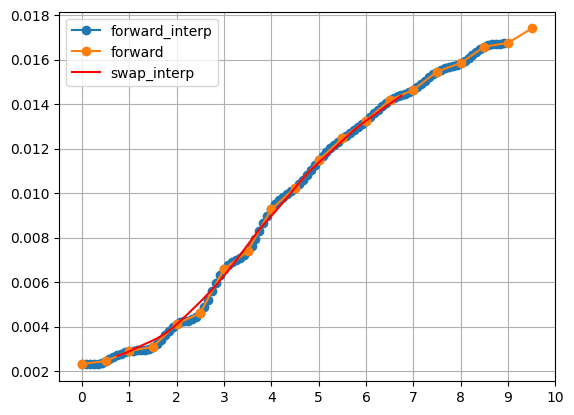

In [202]:
# =============================================================================
#                               TIME INDEXING
# =============================================================================
# create tenors with semiannual (0.5) intervals, starting from 0 ending at 10 (years)
tenor = np.arange(1, 21)*0.5

# tenors with semiannual (0.5) intervals, starting from 0 ending at 10 (years)
zcb_dates_semiannual = np.concatenate(([0],tenor)) # used for zcb and fwd rates

# remove last index as the tenor is pointing to the start of the forward rates
fwd_start_dates_monthly = (zcb_dates_semiannual[:-1] * 12).astype(int) 

# tenors with monthly (1/12) intervals, starting from 0 ending at 10 (years)
tenors_all_monthly = np.linspace(0, 10, 121)
# =============================================================================




# =============================================================================
#           Create the forard curve starting from the spot rate
# =============================================================================
# create full 6m LIBOR forward curve starting from spot rate
libor_6m_spot = raw_spot_df.loc[raw_spot_df["Tenor"] == 0.5, "Spot"].iloc[0] / 100
forwards = np.array(cap_df["Reset Rate"]/100)
fwd_w_spot = np.concatenate(([libor_6m_spot], forwards))

#fwd_w_spot = np.arange(len(fwd_w_spot))/len(fwd_w_spot)/100 + 0.01


# create zcb from the forward rates
discount_factors = 1 / (1 + fwd_w_spot * 0.5)
zcb_from_fwd = np.concatenate(([1], np.cumprod(discount_factors)))

# interpolate to monthly values
zcb_cs = interpolate.CubicSpline(zcb_dates_semiannual, zcb_from_fwd)
zcb_monthly = zcb_cs(tenors_all_monthly)
# =============================================================================




# =============================================================================
#          Construct dataframe with tenors, zcb and forward rates
# =============================================================================
df = pd.DataFrame({'Tenor': tenors_all_monthly, 'zcb': zcb_monthly, 'Forward': np.nan})
df.loc[fwd_start_dates_monthly, 'Forward'] = fwd_w_spot
# add column with backfilled forward indices, such that the value in this column is 0 from 0 to 5, 1 from 6 to 11, 2 from 12 to 17, etc.    
df['Forward Index'] = np.arange(len(df)) // 6

# =============================================================================





# =============================================================================
#                       Interpolate the forward rates
# =============================================================================
def get_indices(s, df):
    i_s = df.index[(df['Tenor'] <= s) & (df['Forward'].isna() == False)].max()
    i_s_p1 = df.index[(s < df['Tenor']) & (df['Forward'].isna() == False)].min()
    return i_s, i_s_p1

def get_gamma(s, df):


    i_s, i_s_p1 = get_indices(s, df)
    # get the closest canonical forward rate before s 
    f_is = df.loc[i_s, 'Forward']
    
    # Calculate f_s, the forward from s to i_s_p1. gets shorter as s approaches i_s_p1
    p_0_s = df.loc[np.isclose(df['Tenor'], s, atol=1e-4), 'zcb'].values[0]
    # get the zcb price 
    p_0_isp1 = df.loc[i_s_p1, 'zcb']
    mod_accrual_factor = df.loc[i_s_p1, 'Tenor'] - s
    # p(0,s,sp1) = p(0,sp1)/p(0,s)
    # isp1 is a higher forward rate, therefore the zcb price is lower, which makes f_s higher
    f_s = ((p_0_s/p_0_isp1) - 1) / mod_accrual_factor
    
    gamma =  f_s/ f_is


    return gamma, mod_accrual_factor

def add_interp_rates(df):
    """calculates the interpolated rates for a list of tenors s_list and adds them to the supplied dataframe"""
    s_values = df['Tenor'][:-7]
    gamma_list = [get_gamma(s, df)[0] for s in s_values]
    annuity_factor_list = [get_gamma(s, df)[1] for s in s_values]

    df.loc[s_values.index, 'gamma'] = gamma_list 
    df['annuity_factor'] = 0.5
    #df.loc[s_values.index, 'annuity_factor'] = annuity_factor_list
    # add the f_is index to the gamma values
    # we start by finding i_s for each s
    i_s_list = [get_indices(s, df)[0] for s in s_values]    
    df.loc[s_values.index, 'i_s'] = np.array(i_s_list, dtype=int).astype(int)
    return df



df = add_interp_rates(df)
# =================================================================



# =============================================================================
#                         create swap rate weights
# =============================================================================
def get_semiannual_tenors_relative(start, tenor):
    end = start + tenor
    # Start at start + 0.5, step by 0.5, go up to and including end
    return np.arange(start + 0.5, end + 1e-8, 0.5)

def float_safe_mask(df_tenors, target_tenors, atol=1e-8):
    mask = np.zeros_like(df_tenors, dtype=bool)
    for t in target_tenors:
        mask |= np.isclose(df_tenors, t, atol=atol)
    return mask


def swap_weights(start, df, tenor=2):
    # Compute end of swap

    # Get semiannual cash flow times relative to swap start
    semi_tenors = get_semiannual_tenors_relative(start, tenor)
    #print(f"start: {start}, end: {semi_tenors[-1]}")
    #print(f"start of swap: {start}")
    #print(f"weight tenors (should be 0.5 ahead of forward rate tenors): {semi_tenors=}")
    # Filter to only those tenor points in the DataFrame
    mask = float_safe_mask(df["Tenor"].values, semi_tenors)
    #print(mask, df.loc[mask, 'Tenor'])

    
    # Pull corresponding zero-coupon prices and annuity weights
    zcb = df.loc[mask, 'zcb']
    af = df.loc[mask, 'annuity_factor']  # e.g., accrual fractions (usually 0.5)
    # Compute swap annuity and weights
    annuity = (zcb * af).sum()
    weights = (zcb * af) / annuity
    # Assert normalization
    assert np.isclose(weights.sum(), 1), "Swap weights do not sum to 1, its is {}".format(weights.sum())

    return weights




def get_swap_rate (start, df, interp_funcs, tenor=2):
    ws = swap_weights(start, df, tenor)

    rates_idx = df.loc[ws.index, 'i_s'].dropna().astype(int)

    index_actual = ws.index
    index_is = rates_idx.values
    #print("index_actual",index_actual.values)
    #print("index_is",index_is)
    semi_tenors = get_semiannual_tenors_relative(start, tenor)
    mask = float_safe_mask(df["Tenor"].values, semi_tenors-0.5)
    tenors = df.loc[mask, 'Tenor']
    #print(f"Forward rate tenors (s in f(0,s,t)): {tenors.values}")
    
    # gamma gets us from s to i_sp1
 
    #print(fwd_interp)
    fwd_interp = np.array([interp_funcs[i](df['Forward']) for i in tenors])
    #print(f"Forward rates: {fwd_interp}")
    #print(f"Swap weights: {ws.values}")

    return (ws.values * fwd_interp).sum()

#def get_frozon_Ws()

def get_all_swaps(df,interp_funcs, tenor=2):
    starts = df['Tenor'][:-(tenor*12*2)].values
    
    #print(starts)
    swap_rates = [get_swap_rate(start, df, interp_funcs, tenor) for start in starts]
    #plt.plot(starts+1, swap_rates)
    #plt.plot(df['Tenor'].loc[df['Forward'].dropna().index],df['Forward'].dropna())
    return swap_rates, starts
 


def create_all_tenor_forward_funcs(df, tenor=0.5):
    """
    Creates forward rate functions for all valid tenors in df.
    
    Parameters:
    df (pd.DataFrame): DataFrame with 'Tenor', 'Forward', 'gamma' columns
    tenor (float): Forward tenor period (default 0.5)
    
    Returns:
    dict: Dictionary mapping starting tenors to forward rate functions
    """
    # Get all tenor values
    all_tenors = df['Tenor'].values
    
    # Precompute gamma values for all tenors (do this once)
    gamma_dict = {}
    for t in np.unique(np.concatenate([all_tenors, all_tenors + tenor])):
        mask = np.isclose(df['Tenor'].values, t, atol=1e-4)
        if any(mask):
            gamma_dict[t] = df.loc[mask, 'gamma'].iloc[0]
    
    # Determine valid tenors (skip last 7 indices)
    max_valid_tenor = all_tenors[-8]
    valid_tenors = [t for t in all_tenors if t + tenor <= max_valid_tenor]
    # Factory function to create closure with proper variable binding
    def create_forward_func(s):
        # Precompute static quantities
        tau = tenor
        e = s + tau
        
        # Get nearest tenor indices for s and e
        i_s, i_s_p1 = get_indices(s, df)
        i_e, i_e_p1 = get_indices(e, df)
        
        # Get actual tenor times
        T_i_s_p1 = df.loc[i_s_p1, 'Tenor']
        T_i_e_p1 = df.loc[i_e_p1, 'Tenor']
        
        # Get gamma values from precomputed dict
        gamma_s = gamma_dict.get(s)
        gamma_e = gamma_dict.get(e)
        
        # Theta values (constant)
        theta_s = T_i_s_p1 - s
        theta_e = T_i_e_p1 - e
        
        # Indices for canonical rate product
        rate_indices = df.loc[i_s_p1:i_e, 'Forward'].dropna().index
        
        def forward_func_timestep(forward_rates: pd.Series) -> float:
            forward_rates = forward_rates
            f_is_t = forward_rates[i_s]
            f_ie_t = forward_rates[i_e]
            
            f_s = f_is_t * gamma_s
            f_e = f_ie_t * gamma_e
            
            rates = forward_rates[rate_indices]
            
            canon_rates = np.prod(1/(1 + rates * tau))
            
            p_s_e = (1 + f_e * theta_e) / (1 + f_s * theta_s) * canon_rates

            f_interp_2 = (1 / p_s_e - 1) / tau 
            return f_interp_2
        
        return forward_func_timestep
    
    # Create forward functions for each valid tenor
    forward_funcs = {s: create_forward_func(s) for s in valid_tenors}
    
    return forward_funcs
all_forwards = create_all_tenor_forward_funcs(df)

sr = get_swap_rate(3/12, df, all_forwards)

srs, starts = get_all_swaps(df, all_forwards, 2)  
print((starts*2+2)/2)
print(starts+1)
forward_curve = np.zeros(len(df['Tenor'].iloc[:-13]))
for i, tenor in enumerate(df['Tenor'].iloc[:-13]):
    #print(tenor)
    forward_curve[i] = all_forwards[tenor](df['Forward'])
plt.plot(df['Tenor'].iloc[:-13], forward_curve,'o-', label='forward_interp')
plt.plot(df['Tenor'].loc[df['Forward'].dropna().index],df['Forward'].dropna(), 'o-', label='forward')
plt.plot(starts+(2-0.5)/2, srs, '-', label='swap_interp', color='red')
# make grid for 0, 1, 2...10 years on the x axis
x = np.arange(0, 10.1, 1)
plt.legend()
plt.xticks(x)
plt.grid()


In [198]:
df['Forward'].values

array([0.0023178,       nan,       nan,       nan,       nan,       nan,
       0.0024451,       nan,       nan,       nan,       nan,       nan,
       0.0028982,       nan,       nan,       nan,       nan,       nan,
       0.0030861,       nan,       nan,       nan,       nan,       nan,
       0.004112 ,       nan,       nan,       nan,       nan,       nan,
       0.0046043,       nan,       nan,       nan,       nan,       nan,
       0.0065795,       nan,       nan,       nan,       nan,       nan,
       0.0073824,       nan,       nan,       nan,       nan,       nan,
       0.0092758,       nan,       nan,       nan,       nan,       nan,
       0.0102283,       nan,       nan,       nan,       nan,       nan,
       0.0114696,       nan,       nan,       nan,       nan,       nan,
       0.0124572,       nan,       nan,       nan,       nan,       nan,
       0.0132631,       nan,       nan,       nan,       nan,       nan,
       0.014182 ,       nan,       nan,       nan, 

In [205]:
#sr = get_all_swaps(df, all_forwards, 2)
fwds = df['Forward'].values
for i in range(2000):
    for forward in all_forwards.values():
        forward(fwds)


In [ ]:
df

In [200]:
df

,Tenor,zcb,Forward,Forward Index,gamma,annuity_factor,i_s
0,0.000000,1.000000,0.002318,0,1.000000,0.5,0.0
1,0.083333,0.999799,NaN,0,0.991243,0.5,0.0
2,0.166667,0.999602,NaN,0,0.984890,0.5,0.0
3,0.250000,0.999410,NaN,0,0.980943,0.5,0.0
4,0.333333,0.999220,NaN,0,0.979400,0.5,0.0
...,...,...,...,...,...,...,...
116,9.666667,0.909966,NaN,19,NaN,0.5,NaN
117,9.750000,0.908663,NaN,19,NaN,0.5,NaN
118,9.833333,0.907347,NaN,19,NaN,0.5,NaN
119,9.916667,0.906018,NaN,19,NaN,0.5,NaN


In [209]:


class LMMSABR():
    def __init__(self, rho_mat, theta_mat, phi_mat, g_params, h_params, epsilon_exp, s0_exp, yell=True):
        self.rho_mat = rho_mat
        self.theta_mat = theta_mat
        self.phi_mat = phi_mat
        self.g = partial(get_instant_vol_func, params=g_params)
        self.h = partial(get_instant_vol_func, params=h_params)
        self.epsilon_exp = epsilon_exp
        self.s0_exp = s0_exp
        if yell:
            print("h SHOULD PERHAPS BE FORCED TO BE POSITIVE")
    
    @staticmethod
    def getInstantaneousVolatility(t, expiry , params):
        '''
        Return the instantaneous volatility ,
        computed in terms of the parametric
        form proposed by Rebonato , at a given time t.
        @var t: time at which we want to compute the
        instantaneous volatility (in years)
        @var expiry: caplet expiry (in years)
        @var a: parameter a of Rebonato ’s instant. vol. function
        @var b: parameter b of Rebonato ’s instant. vol. function
        @var c: parameter c of Rebonato ’s instant. vol. function
        @var d: parameter d of Rebonato ’s instant. vol. function
        
        #g(T - t) & h(T - t)
        '''
        a,b,c,d = params
        tau = expiry - t
        instantaneous_vol = (a + b * tau) * np.exp(-c * tau) + d
        return instantaneous_vol
    

    def zcb_price(self, t, T,S, forwards):
        pass

    def get_fwd_drift(self, t, f_t: np.ndarray):
        """find the drift of the forward rate given all longer maturity forwards"""
        pass
    def get_vol_drift(self, t, f_t):
        pass

    def simulate(self, f_0, tenors, num_sim, tau):
        self.tenors = tenors
        self.num_sim = num_sim

        t_end = tenors[-1]

        f_sim = np.zeros((num_sim, len(tenors)))*np.nan
        

        dt = t_end/num_sim
        print(f"{dt=}")

        dt_sqrt = math.sqrt(dt)
        t_arr = np.linspace(dt, t_end, num_sim)

        # precompute h and g
        ttm_mat = tenors - t_arr.reshape(-1,1)
        ttm_mat[ttm_mat<0] = 0
        h_mat = self.h(ttm_mat)
        g_mat = self.g(ttm_mat)

        # precompute random draws
        dZ_f = np.random.multivariate_normal(np.zeros(len(tenors)), self.rho_mat, num_sim) * dt_sqrt
        dW_s = np.random.multivariate_normal(np.zeros(len(tenors)), self.theta_mat, num_sim) * dt_sqrt
        
        # precompute all s_t
        # start by multiplying epsilon_exp with the random draws along the forwards on all timesteps
        s_mat = s0_exp * np.cumprod(1 + self.epsilon_exp.reshape(1,-1) * dW_s * h_mat, axis=0)
        alpha_mat = g_mat * s_mat
        
        # we use Q^{T_j} measure, where j=len(tenors)-1, so the last tenor is a martingale.
        # we can compute the value of the last tenor directly from the s_mat values
        f_sim[0] = f_0
        
        drift_correction = np.zeros(len(tenors))
        drift_shared = np.zeros(len(tenors))
        for i in range(1, num_sim):
            drift_correction.fill(0)
            drift_shared.fill(0)
            # next loop runs from longest to shortest tenor
            for tenor in np.arange(len(tenors)-1, -1, -1):
                if ttm_mat[i, tenor] > 0:    
                    alpha_t, dZ_f_t,  f_t = alpha_mat[i-1, tenor], dZ_f[i-1,tenor], f_sim[i-1,tenor]
                    f_beta_t = f_t**0.5
                    df_t =  f_beta_t*alpha_t*dZ_f_t
                    f_t += df_t
                    
                    drift_f = (-g_mat[i, tenor] * s_mat[i, tenor] * f_beta_t * drift_shared[tenor])
                    
                    f_sim[i,tenor] = drift_f + f_t
                    if tenor > 0:
                        drift_correction[tenor-1] = rho_mat[tenor-1, tenor] * tau * g_mat[i,tenor] * s_mat[i, tenor] * f_beta_t / (1 + tau * f_t)
                        drift_shared[tenor-1] = np.sum(drift_correction[tenor-1:])
        self.f_sim = f_sim
        return f_sim
    
    def plot(self):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Create mesh grid for x (time) and y (tenors)
        X = np.arange(self.num_sim)
        Y = self.tenors
        X, Y = np.meshgrid(X, Y)
        
        # Transpose f_sim to match the grid shape
        Z = f_sim.T

        # Create surface plot
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
        
        # Add labels and colorbar
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Tenors')
        ax.set_zlabel('Forward Rates')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        
        plt.show()
                
lmm = LMMSABR(rho_mat, theta_mat, phi_mat, params_g, params_h, epsilon_exp, s0_exp=s0_exp, yell=False)
f_sim = lmm.simulate(forwards,fwd_tenors, 1000, tau=0.5)

print(lmm.h(0.1))
#lmm.plot()

#plt.hist(lmm.f_sim[:,-1], bins=100)


dt=0.01
2.5076370370318988


In [16]:
#define arguments to use for LMM SABR Simulation
no_of_sim = 2 #change this
steps_per_year = 20
F_0 = forwards #from caplet_fitting.py
s_0 = s0_exp #from caplet_fitting.py
epsilon = epsilon_exp #from caplet_fitting.py
corr_fwd_fwd_full_rank = doust_fwd_fwd[:19, :19]
corr_vol_vol_full_rank = doust_vol_vol[:19, :19]
corr_fwd_vol = corr_fwd_vol #from caplet_fitting.py
no_of_factors = 6 #correlation factors reduce rank
beta = np.repeat(0.5, len(F_0))
tau = 0.5 #semi-annual forwards
fixing_time_grid = np.arange(1,20)/2
print(fixing_time_grid)

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8.  8.5 9.
 9.5]


In [17]:
simulated_fwd_full = simulateSABRLMM (no_of_sim  = no_of_sim, steps_per_year = steps_per_year,
                          fixing_time_grid = fixing_time_grid, F_0  = F_0, s_0  = s_0,
                          epsilon =epsilon, corr_fwd_fwd_full_rank = corr_fwd_fwd_full_rank,
                          corr_vol_vol_full_rank = corr_vol_vol_full_rank,
                          corr_fwd_vol = corr_fwd_vol, no_of_factors = no_of_factors ,
                          beta = beta, tau = tau, params_g = params_g, params_h = params_h)

plt.plot(simulated_fwd_full[:,:,1].T)
plt.show()

NameError: name 'simulateSABRLMM' is not defined

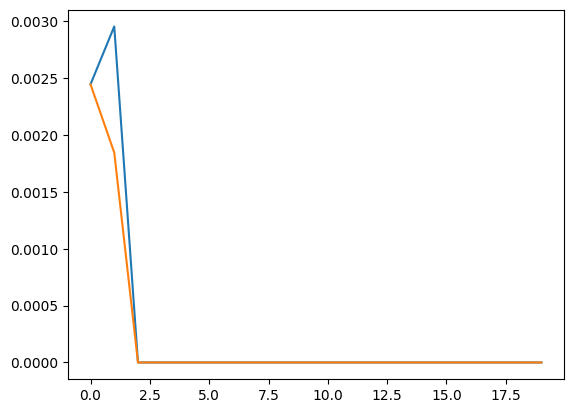

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad

# Given function definitions
def g_tau(tau, a, b, c, d):
    """eq 2, also the function for sigma_i(tau_i)"""
    val = (a + b * tau) * np.exp(-c * tau) + d
    return np.maximum(val, 1e-6)

def h_tau(tau, ah, bh, gamma, delta):
    """eq 19, also the function for nu_i(tau_i) (volatility of volatility)"""
    val = (ah + bh * tau) * np.exp(-gamma * tau) + delta
    return np.maximum(val, 1e-6)

# Integral of g^2 over [0, T]
def g_hat(T, a, b, c, d):
    integral, _ = quad(lambda tau: g_tau(tau, a, b, c, d) ** 2, 0, T)
    return np.sqrt(integral / T)

# Integral of h^2 over [0, T]
def h_hat(T, ah, bh, gamma, delta):
    integral, _ = quad(lambda tau: h_tau(tau, ah, bh, gamma, delta) ** 2, 0, T)
    return np.sqrt(integral / T)




def initial_vol(rho_arr, W_arr, k_0_arr, g_tau_arr, T):
    """
    Computes the initial volatility Σ₀ using equation (63).

    Parameters:
    - rho_arr: (numpy array) Correlation matrix ρ_ij of forward rates.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - T: (float) Maturity time T.

    Returns:
    - Σ₀: (float) The initial volatility term.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j dt
    integral_g = np.trapz(g_tau_arr @ g_tau_arr.T, dx=T / g_tau_arr.shape[1])
    
    # Compute the double sum term
    sum_term = 0
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            sum_term += rho_arr[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_g[i, j]
    
    # Compute Σ₀
    Sigma_0 = np.sqrt((1 / T) * sum_term)
    
    return Sigma_0

initial_vol()

import numpy as np

def compute_V(Sigma_0, rho_arr, theta_arr, W_arr, k_0_arr, g_tau_arr, h_hat_tau_arr, T):
    """
    Computes V using the given formula.

    Parameters:
    - Sigma_0: (float) Initial volatility term Σ₀.
    - rho_arr: (numpy array) Correlation matrix ρ_ij of forward rates.
    - theta_arr: (numpy array) Additional correlation matrix θ_ij.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - h_hat_tau_arr: (numpy array) Function \( \hat{h}_{ij}(t) \) over time.
    - T: (float) Maturity time T.

    Returns:
    - V: (float) The computed volatility term V.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j (h_hat_ij(t))² t dt using trapezoidal rule
    t_grid = np.linspace(0, T, h_hat_tau_arr.shape[1])  # Time grid
    integral_h = np.trapz(g_tau_arr @ g_tau_arr.T * h_hat_tau_arr**2 * t_grid, dx=T / h_hat_tau_arr.shape[1])

    # Compute the double sum term
    sum_term = 0
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            sum_term += 2 * rho_arr[i, j] * theta_arr[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_h[i, j]
    
    # Compute V
    V = (1 / (Sigma_0 * T)) * np.sqrt(sum_term)
    
    return V

import numpy as np

def compute_Omega(rho_mat, phi_mat, W_arr, k_0_arr, g_tau_arr, h_hat_tau_arr, V, Sigma_0, T):
    """
    Computes Ω_ij using equation (76).

    Parameters:
    - rho_mat: (numpy array) Correlation matrix ρ_ij of forward rates.
    - phi_mat: (numpy array) Correlation matrix φ_ij between forward rates and their volatilities.
    - W_arr: (numpy array) Initial Brownian motion weights W_i^0.
    - k_0_arr: (numpy array) Initial volatility scaling factors k_0^i.
    - g_tau_arr: (numpy array) Instantaneous volatility function g^i over time.
    - h_hat_tau_arr: (numpy array) Function \( \hat{h}_{ij}(t) \) over time.
    - V: (float) Computed volatility term from equation (previous).
    - Sigma_0: (float) Initial volatility term.
    - T: (float) Maturity time.

    Returns:
    - Omega_mat: (numpy array) Matrix of Ω_ij values.
    """
    no_of_fwds = len(W_arr)
    
    # Compute the integral part ∫₀ᵀ g^i g^j (h_hat_ij(t))² t dt using trapezoidal rule
    t_grid = np.linspace(0, T, h_hat_tau_arr.shape[1])  # Time grid
    integral_h = np.trapz(g_tau_arr @ g_tau_arr.T * h_hat_tau_arr**2 * t_grid, dx=T / h_hat_tau_arr.shape[1])

    # Compute Ω_ij matrix
    Omega_mat = np.zeros((no_of_fwds, no_of_fwds))
    denominator = (V * Sigma_0 * T) ** 2  # (V Σ₀ T)²
    
    for i in range(no_of_fwds):
        for j in range(no_of_fwds):
            numerator = 2 * rho_mat[i, j] * phi_mat[i, j] * W_arr[i] * W_arr[j] * k_0_arr[i] * k_0_arr[j] * integral_h[i, j]
            Omega_mat[i, j] = numerator / denominator
    
    return Omega_mat


import numpy as np

def compute_Phi(Omega_mat, phi_mat, atol=1e-6):
    """
    Computes Φ using equation (78) and verifies Ω_ij constraints.

    Parameters:
    - Omega_mat: (numpy array) Weighting matrix Ω_ij.
    - phi_mat: (numpy array) Correlation matrix φ_ij between forward rates and their volatilities.
    - atol: (float) Tolerance for floating-point comparisons (default: 1e-6).

    Returns:
    - Phi: (float) The computed Φ value.
    """
    # Check that Ω_ij >= 0
    if np.any(Omega_mat < -atol):  # Allow small numerical noise
        raise ValueError("Error: Some elements in Omega_mat are negative!")

    # Check that sum of Ω_ij is close to 1
    Omega_sum = np.sum(Omega_mat)
    if not np.isclose(Omega_sum, 1.0, atol=atol):
        raise ValueError(f"Error: Sum of Ω_ij is {Omega_sum}, expected 1.0")

    # Compute Φ as the weighted sum of Ω_ij * φ_ij
    Phi = np.sum(Omega_mat * phi_mat)
    
    return Phi

import numpy as np

def compute_B(w_arr, beta_arr, atol=1e-6):
    """
    Computes B using equation (79), ensuring w_k acts as valid weights.

    Parameters:
    - w_arr: (numpy array) Weight vector w_k, corresponding to the swap periods.
    - beta_arr: (numpy array) Corresponding beta values β_k for each period.
    - atol: (float) Tolerance for floating-point comparisons (default: 1e-6).

    Returns:
    - B: (float) The computed exponent B.
    """
    # Truncate arrays to match the running time of the swap
    w_arr = w_arr
    beta_arr = beta_arr

    # Ensure w_k are valid weights (sum to 1)
    w_sum = np.sum(w_arr)
    if not np.isclose(w_sum, 1.0, atol=atol):
        raise ValueError(f"Error: Sum of w_k is {w_sum}, expected 1.0")

    # Compute B as the weighted sum over the swap's running period
    B = np.sum(w_arr * beta_arr)
    
    return B

